In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


%matplotlib inline

In [ ]:

df = pd.read_csv('data_preprocessed_with_all_sectors.csv')


df.head()


,Price,Price/Earnings,Dividend_Yield,Earnings/Share,52_Week_Low,52_Week_High,Market_Cap,EBITDA,Price/Sales,Price/Book,...,Sector_Consumer Staples,Sector_Energy,Sector_Financials,Sector_Health Care,Sector_Industrials,Sector_Information Technology,Sector_Materials,Sector_Real Estate,Sector_Telecommunication Services,Sector_Utilities
0,0.878344,-0.008454,0.280215,0.743147,0.875014,0.861718,0.986142,0.796009,0.125507,-0.035195,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.324371,0.076259,-0.489462,-0.382941,-0.349252,-0.327918,-0.425974,-0.432863,-0.108525,-0.090795,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,-0.353727,-0.052652,0.004876,-0.643643,-0.373496,-0.390377,0.582168,0.315342,-0.061133,-0.126005,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.032340,-0.128771,0.388497,-0.095082,0.018386,-0.223349,1.457061,0.979604,0.671617,0.129711,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.343130,0.020029,-0.121474,0.294160,0.253414,0.291456,0.545135,0.300682,-0.387530,-0.043217,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [ ]:

import numpy as np

def create_windows(features, target, window_size):
    X = []
    y = []
    for i in range(len(features) - window_size):
        # Each window is a block of consecutive rows (days) from the features DataFrame.
        X.append(features.iloc[i:i+window_size].values)
        # The target for the window is the value of 'target' immediately after the window.
        y.append(target.iloc[i+window_size])
    return np.array(X), np.array(y)

window_size = 5

X, y = create_windows(features_scaled, target, window_size)

print("Shape of input (X):", X.shape) 
print("Shape of target (y):", y.shape)


Shape of input (X): (490, 5, 20)
Shape of target (y): (490,)


In [ ]:

# Split the data into training and testing sets (80% train, 20% test).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


# Determine the input dimensions for the model.
n_timesteps = X_train.shape[1]   
n_features = X_train.shape[2]    


Training samples: 392
Testing samples: 98


In [ ]:


model = Sequential()

# First Conv1D layer with 64 filters, kernel size 2, and padding='same'.
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same', 
                 input_shape=(n_timesteps, n_features)))
model.add(BatchNormalization())

# Second Conv1D layer with 64 filters and padding='same'.
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())

# MaxPooling to reduce dimensionality but not too aggressively.
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# --- Second Convolutional Block ---
# Conv1D layer with 128 filters, kernel size 2, and padding='same'.
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())

# Another Conv1D layer with 128 filters and padding='same'.
model.add(Conv1D(filters=128, kernel_size=2, activation='relu', padding='same'))
model.add(BatchNormalization())

# Further downsample with MaxPooling.
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.5))

# --- Fully Connected Layers ---
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))

# Output layer: single neuron with linear activation for regression.
model.add(Dense(1, activation='linear'))

# Compile the model with Adam optimizer and mean squared error (MSE) loss.
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Display the model summary.
model.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_19 (Conv1D)          (None, 5, 64)             2624      
                                                                 
 batch_normalization_18 (Bat  (None, 5, 64)            256       
 chNormalization)                                                
                                                                 
 conv1d_20 (Conv1D)          (None, 5, 64)             8256      
                                                                 
 batch_normalization_19 (Bat  (None, 5, 64)            256       
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 2, 64)            0         
 1D)                                                             
                                                      

In [ ]:
# %%
# Train the model using the training set.
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/50
13/13 [==============================] - 0s 6ms/step - loss: 0.1871 - val_loss: 2.1295
Epoch 2/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2636 - val_loss: 2.1160
Epoch 3/50
13/13 [==============================] - 0s 6ms/step - loss: 0.2213 - val_loss: 2.1218
Epoch 4/50
13/13 [==============================] - 0s 5ms/step - loss: 0.2222 - val_loss: 2.1290
Epoch 5/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2014 - val_loss: 2.1370
Epoch 6/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2454 - val_loss: 2.1301
Epoch 7/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2492 - val_loss: 2.1395
Epoch 8/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2093 - val_loss: 2.1432
Epoch 9/50
13/13 [==============================] - 0s 7ms/step - loss: 0.2122 - val_loss: 2.1393
Epoch 10/50
13/13 [==============================] - 0s 4ms/step - loss: 0.2033 - val_loss: 2.1325
Epoch 11/50
13/13 [

In [ ]:

# Evaluate the model on the test set.
test_loss = model.evaluate(X_test, y_test)
print("Test Loss (MSE):", test_loss)

# Generate predictions on the test set.
y_pred = model.predict(X_test)

# Calculate additional evaluation metrics.
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nEvaluation Metrics on Test Set:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R² Score: {r2:.4f}")


4/4 [==============================] - 0s 1ms/step - loss: 2.1619
Test Loss (MSE): 2.1618874073028564
4/4 [==============================] - 0s 993us/step

Evaluation Metrics on Test Set:
Mean Squared Error (MSE): 2.1619
Root Mean Squared Error (RMSE): 1.4703
Mean Absolute Error (MAE): 0.5555
R² Score: -0.0541


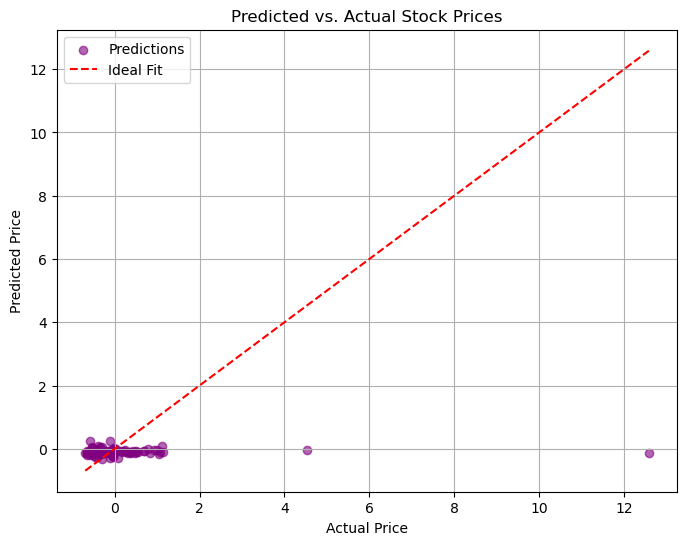

In [ ]:
# %%
# Scatter plot for Predicted vs. Actual Values.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='purple', label='Predictions')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs. Actual Stock Prices')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Fit')
plt.legend()
plt.grid(True)
plt.show()


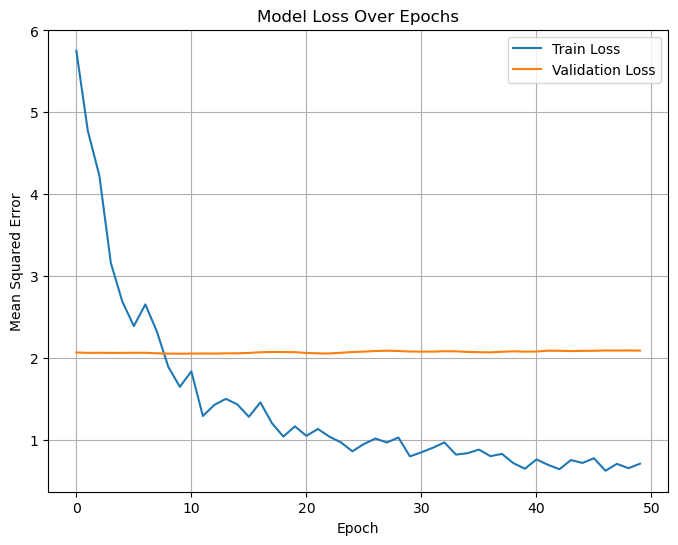

In [17]:
# %%
# Plot the training and validation loss over epochs.
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()
